# Projet d'apprentissage profond pour les images - Quang-Duy Nguyen, Morgan Ramadani
## 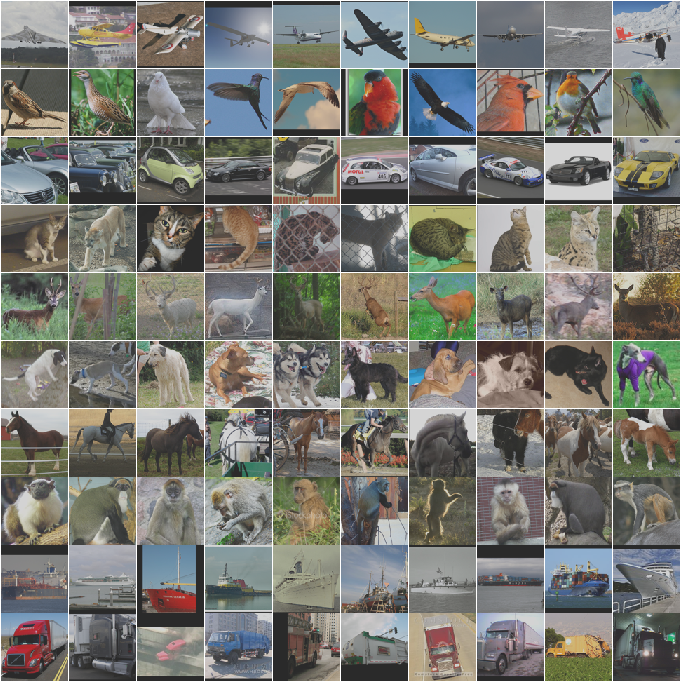

__Abstract__
##
Dans ce projet, nous nous concentrons sur la classification d'images en utilisant des techniques de deep learning sur le jeu de données STL-10. Les images du jeu de données ont une taille de 96x96x3, ce qui signifie qu'elles sont en couleur (RGB) et ont une résolution de 96 pixels de largeur et de hauteur.

Nous commencerons par explorer des approches classiques en utilisant des réseaux de neurones à convolution (CNN). Ces réseaux sont bien adaptés à la classification d'images en raison de leur capacité à extraire des caractéristiques à différentes échelles spatiales. Nous évaluerons une architectures de CNN sur STL-10. Cette architecture Nous servira de base pour la suite.

Ensuite, nous améliorerons notre modèle de base en ajoutant une couche d'attention. Cette couche permettra au modèle de se concentrer sur les parties les plus informatives des images et de mieux discriminer les différentes classes. Nous évaluerons l'impact de l'ajout de cette couche d'attention sur les performances de classification.

De plus, nous introduirons un mécanisme de résidu dans notre modèle. Les connexions résiduelles permettent d'améliorer la propagation du signal et de faciliter l'apprentissage profond en évitant les problèmes de disparition du gradient. Nous évaluerons l'efficacité de l'ajout de ces connexions résiduelles sur les performances de notre modèle.

Nous aborderons la question de l'augmentation des données. L'augmentation des données est une technique couramment utilisée pour augmenter la taille du jeu de données d'entraînement en appliquant des transformations telles que la rotation, le redimensionnement, l'ajout de perspective, etc. Nous évaluerons l'impact de l'augmentation des données sur les performances de notre modèle.

Ensuite, nous explorerons une approche de self-supervised learning en utilisant un autoencodeur. Nous utiliserons l'autoencodeur pour extraire des caractéristiques pertinentes à partir des images et les utiliserons ensuite pour la phase de classification. Cette approche permet d'apprendre des représentations utiles sans avoir besoin d'étiquettes supervisées.

Enfin nous utiliserons un modèle pré entrainé pour effectuer l'extraction de features. Nous avons choisi d'utiliser le modèle CLIP. CLIP (Contrastive Language-Image Pretraining) est un modèle développé par OpenAI qui permet la compréhension croisée des images et du texte. Il combine un transformateur visuel (ViT) et un transformateur de langage pour apprendre des représentations conjointes des images et du texte. CLIP peut être utilisé pour diverses tâches, notamment la classification d'images, l'apprentissage sans étiquette et la recherche texte-image. Suite à l'extraction des features, nous réaliserons un classification à l'aide d'algorithmes de machine learning classique (RandomForest et LogisticRegression).

En résumé, ce projet vise à explorer différentes approches de deep learning pour la classification d'images sur le jeu de données STL-10. Nous évaluerons l'efficacité des architectures de CNN classiques, ainsi que l'impact de l'ajout de couches d'attention et de connexions résiduelles. Nous étudierons également l'importance de l'augmentation des données et testerons une approche de self-supervised learning avec un autoencodeur pour extraire des caractéristiques pertinentes. Une approche utilisant un modèle pré entrainé pour l'extraction des features sera également explorée. Les résultats obtenus nous permettront de mieux comprendre les meilleures pratiques en matière de classification d'images en deep learning.

## Installation & Imports

In [16]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
import random
# Deprecated
# from keras.preprocessing.image import save_img
from keras.utils import save_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import cv2

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from keras.preprocessing.image import save_img
    # from scipy.misc import imsave

print(sys.version_info)

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    save_img("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

if __name__ == "__main__" :
    # download data if needed
    # download_and_extract()

    # test to check if the image is read correctly
    # with open(DATA_PATH) as f:
        # image = read_single_image(f)
        # plot_image(image)

    # test to check if the whole dataset is read correctly
    # images = read_all_images(DATA_PATH)
    # print(images.shape)

    # labels = read_labels(LABEL_PATH)
    # print(labels.shape)

    # save images to disk
    # save_images(images, labels)
    pass

sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)


In [17]:
# path to the binary files with image data
DATA_PATH = './data/stl10_binary/train_X.bin'
DATA_TEST_PATH = './data/stl10_binary/test_X.bin'

# path to the binary files with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'
LABEL_TEST_PATH = './data/stl10_binary/test_y.bin'

In [18]:
# Loading image data
images = read_all_images(DATA_PATH)
test_images = read_all_images(DATA_TEST_PATH)

labels = read_labels(LABEL_PATH)
test_labels = read_labels(LABEL_TEST_PATH)

## Data Exploration

We check that classes are well balanced

In [19]:
# Check if there is class imbalance
print(np.array(np.unique(labels, return_counts=True)))

[[  1   2   3   4   5   6   7   8   9  10]
 [500 500 500 500 500 500 500 500 500 500]]


In [20]:
print(images.shape)
for i in images :
    if i.shape != (96, 96, 3):
        print('dimension problem')

(5000, 96, 96, 3)


## Splitting Data

In [21]:
# Splitting train data into 80% train, 20% validation splits
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# One hot encode the labels
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels-1, num_classes)
valid_labels = tf.keras.utils.to_categorical(val_labels-1, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels-1, num_classes)


# Check the data sets shape
print("Training set:", train_images.shape, train_labels.shape)
print("Validation set:", val_images.shape, valid_labels.shape)
print("test set:", test_images.shape, test_labels.shape)


Training set: (4000, 96, 96, 3) (4000, 10)
Validation set: (1000, 96, 96, 3) (1000, 10)
test set: (8000, 96, 96, 3) (8000, 10)


## Baseline

Nous allons nous concentrer sur l'accuracy comme métrique. Celle-ci est très parlante et correspond bien aux problèmes de classification. Elle permet de nous rendre compte de la proportion de bons résultats. Cependant elle n'exploite pas l'entièreté de la prédiction faite par la fonction d'activation softmax qui peut nous indique si le modèle s'est trompé de beaucoup ou de peu. L'accucary donne une vision globale de la performance du modèle.
#
Une autre métrique que nous avons envisagé est l'AUC. Elle permet un résultat visuel avec l'affichage de la courbe ROC. Cependant elle est moins parlante que l'accuracy. Un avantage de l'AUC est qu'elle ne prend pas en compte un seuil pour la classification et donne une vision plus détaillée de la performance du modèle.

### Baseline w/o Attention

In [22]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 32)        4640

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
)

Epoch 1/10
63/63 [==============================] - 18s 265ms/step - loss: 7.2889 - accuracy: 0.1900 - val_loss: 2.0747 - val_accuracy: 0.2580
Epoch 2/10
63/63 [==============================] - 19s 309ms/step - loss: 1.8739 - accuracy: 0.3338 - val_loss: 1.8779 - val_accuracy: 0.3400
Epoch 3/10
63/63 [==============================] - 20s 316ms/step - loss: 1.5662 - accuracy: 0.4340 - val_loss: 1.7556 - val_accuracy: 0.3420
Epoch 4/10
63/63 [==============================] - 20s 320ms/step - loss: 1.3833 - accuracy: 0.4922 - val_loss: 1.6845 - val_accuracy: 0.4020
Epoch 5/10
63/63 [==============================] - 20s 326ms/step - loss: 1.2414 - accuracy: 0.5458 - val_loss: 1.7880 - val_accuracy: 0.3870
Epoch 6/10
63/63 [==============================] - 20s 319ms/step - loss: 1.0543 - accuracy: 0.6242 - val_loss: 1.8119 - val_accuracy: 0.4010
Epoch 7/10
63/63 [==============================] - 22s 342ms/step - loss: 0.9409 - accuracy: 0.6595 - val_loss: 1.8624 - val_accuracy: 0.4130

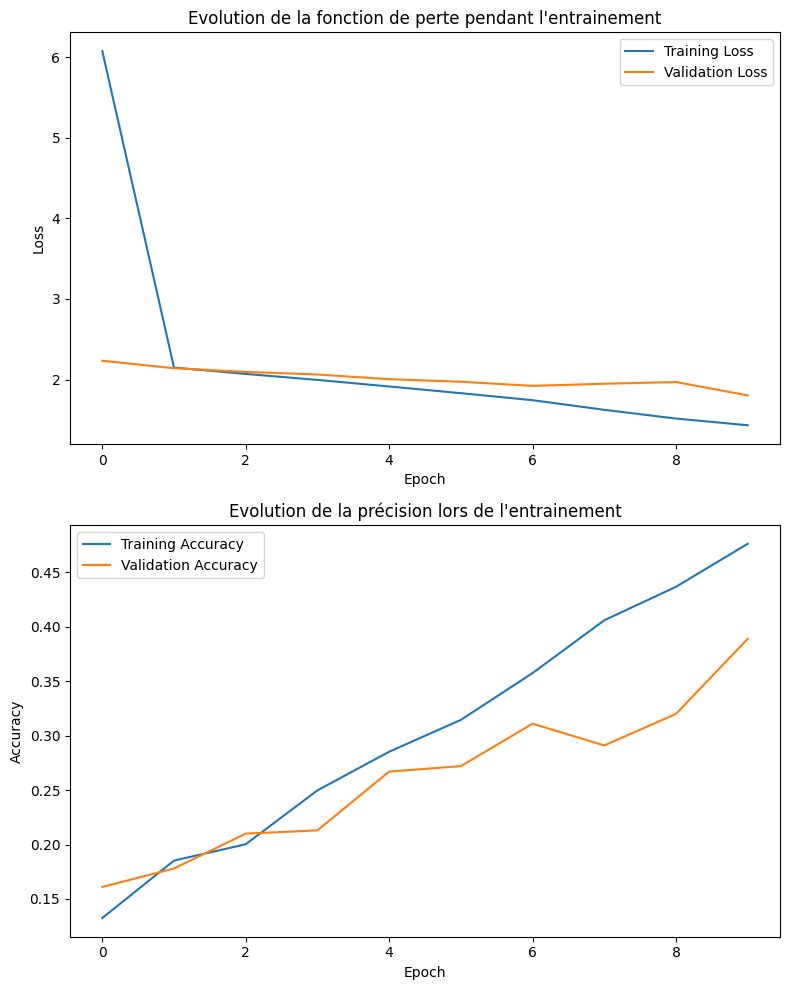

In [11]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

On observe que la fonction de perte évolue conjointement sue les ensembles d'entrainement et de validation. On en déduit que nous n'avons pas d'overfitting. 

In [13]:
baseline_test_loss, baseline_test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {baseline_test_loss}")
print(f"Test Accuracy: {baseline_test_accuracy}")

250/250 [==============================] - 9s 34ms/step - loss: 1.8859 - accuracy: 0.3425
Test Loss: 1.885915756225586
Test Accuracy: 0.3425000011920929


### Baseline w Attention

In [25]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.query = layers.Dense(self.channels)
        self.key = layers.Dense(self.channels)
        self.value = layers.Dense(self.channels)
        self.gamma = self.add_weight("gamma", shape=[1], initializer="zeros", trainable=True)

    def call(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_weights = tf.nn.softmax(tf.matmul(query, key, transpose_b=True))
        attention_output = tf.matmul(attention_weights, value)
        scaled_attention = self.gamma * attention_output + x
        return scaled_attention

In [18]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='linear')(x)
x = SelfAttention()(x) # Ajout d'une couche d'attention
outputs = layers.Dense(10, activation='softmax')(x)

model_baseline_attention = models.Model(inputs=inputs, outputs=outputs, name="model_baseline_attention")
model_baseline_attention.summary()

Model: "model_baseline_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 47, 47, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20

In [19]:
model_baseline_attention.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_baseline_attention.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
)

Epoch 1/10
63/63 [==============================] - 36s 537ms/step - loss: 14.7824 - accuracy: 0.1625 - val_loss: 2.1700 - val_accuracy: 0.1780
Epoch 2/10
63/63 [==============================] - 34s 537ms/step - loss: 2.0609 - accuracy: 0.2562 - val_loss: 2.0645 - val_accuracy: 0.2640
Epoch 3/10
63/63 [==============================] - 36s 579ms/step - loss: 1.9179 - accuracy: 0.3158 - val_loss: 1.9138 - val_accuracy: 0.3140
Epoch 4/10
63/63 [==============================] - 44s 695ms/step - loss: 1.7090 - accuracy: 0.3907 - val_loss: 1.9018 - val_accuracy: 0.3560
Epoch 5/10
63/63 [==============================] - 38s 599ms/step - loss: 1.5034 - accuracy: 0.4735 - val_loss: 1.7938 - val_accuracy: 0.3810
Epoch 6/10
63/63 [==============================] - 37s 587ms/step - loss: 1.4076 - accuracy: 0.5017 - val_loss: 1.9730 - val_accuracy: 0.3490
Epoch 7/10
63/63 [==============================] - 38s 604ms/step - loss: 1.2883 - accuracy: 0.5447 - val_loss: 1.8787 - val_accuracy: 0.380

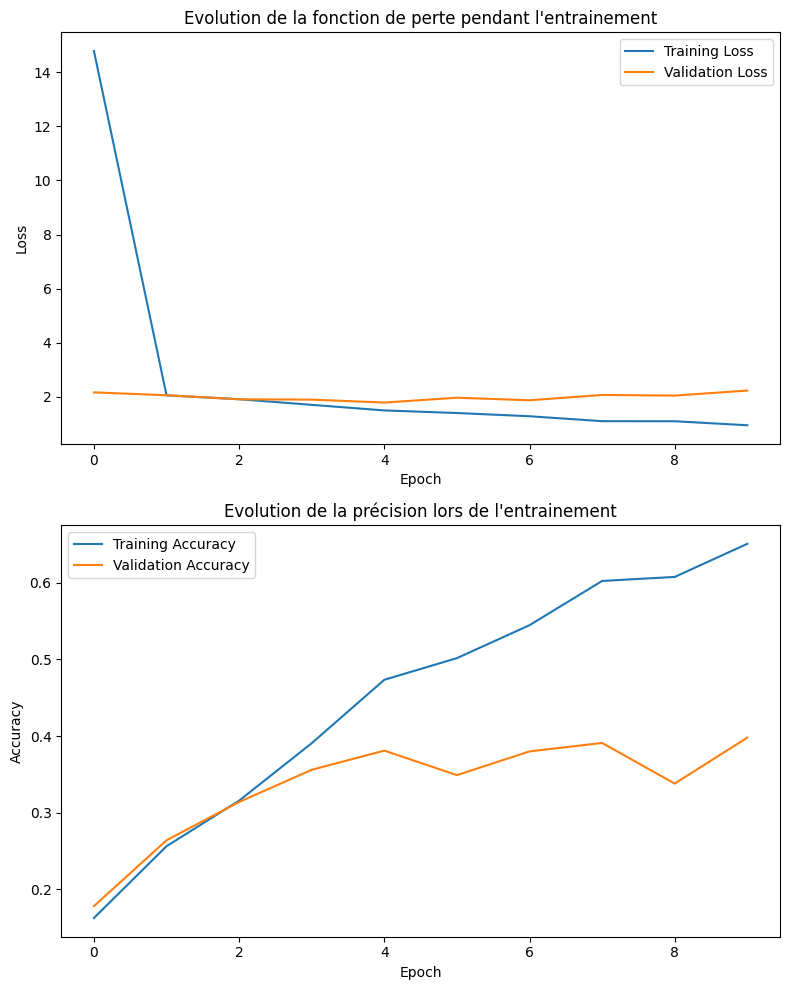

In [21]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Dans ce cas là on peut voir que la précision sur le jeu d'entrainement surévalue les performances de l'algorithme. Nous avons un cas de sur apprentissage. L'implémentation de paramètres de callback peut nous aider à éviter ce problème. Nous avons choisi de ne pas en appliquer pour avoir des conditions d'entrainement similaires entre les différents modèles testés. Cette démarche facilite la comparaison des résultats.

In [20]:
baseline_attention_test_loss, baseline_attention_test_accuracy = model_baseline_attention.evaluate(test_images, test_labels)
print(f"Test Loss: {baseline_attention_test_loss}")
print(f"Test Accuracy: {baseline_attention_test_accuracy}")

250/250 [==============================] - 22s 89ms/step - loss: 2.2379 - accuracy: 0.4006
Test Loss: 2.2378902435302734
Test Accuracy: 0.40062499046325684


## On ajoute également un résidu : 


In [26]:
# Définition du réseau de neurones avec résidu
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x_residual = layers.Dense(64, activation='linear')(x)
x_attention = SelfAttention()(x_residual)
x_combined = layers.Add()([x_residual, x_attention])
outputs = layers.Dense(10, activation='softmax')(x_combined)

model_baseline_attention_residu = models.Model(inputs=inputs, outputs=outputs, name="model_baseline_attention_residu")
model_baseline_attention_residu.summary()

Model: "model_baseline_attention_residu"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 94, 94, 64)           1792      ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 47, 47, 64)           0         ['conv2d_12[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 45, 45, 32)           18464     

In [27]:
model_baseline_attention_residu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_baseline_attention_residu.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
)

Epoch 1/10
63/63 [==============================] - 56s 859ms/step - loss: 20.8924 - accuracy: 0.1922 - val_loss: 2.1771 - val_accuracy: 0.2480
Epoch 2/10
63/63 [==============================] - 48s 762ms/step - loss: 1.9746 - accuracy: 0.3065 - val_loss: 1.9453 - val_accuracy: 0.3100
Epoch 3/10
63/63 [==============================] - 45s 722ms/step - loss: 1.6911 - accuracy: 0.3923 - val_loss: 1.9364 - val_accuracy: 0.3250
Epoch 4/10
63/63 [==============================] - 43s 686ms/step - loss: 1.5225 - accuracy: 0.4498 - val_loss: 1.8908 - val_accuracy: 0.3520
Epoch 5/10
63/63 [==============================] - 44s 697ms/step - loss: 1.3252 - accuracy: 0.5295 - val_loss: 1.8788 - val_accuracy: 0.3860
Epoch 6/10
63/63 [==============================] - 51s 816ms/step - loss: 1.1633 - accuracy: 0.5788 - val_loss: 1.9377 - val_accuracy: 0.4150
Epoch 7/10
63/63 [==============================] - 43s 682ms/step - loss: 1.0212 - accuracy: 0.6375 - val_loss: 1.9183 - val_accuracy: 0.412

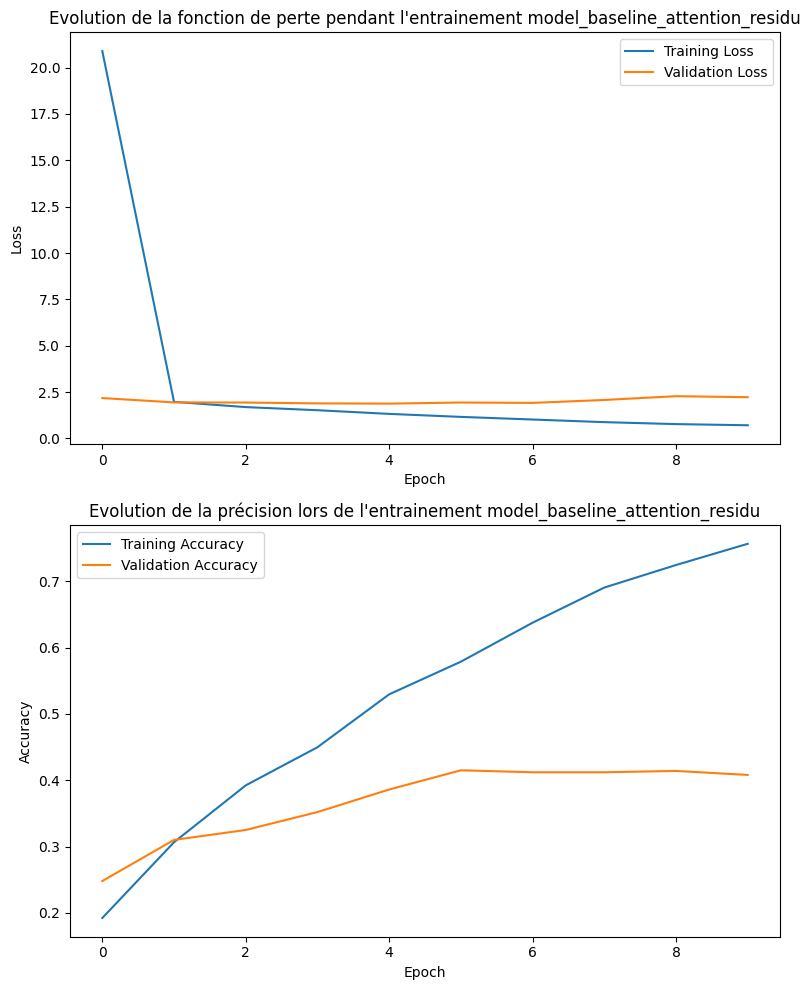

In [28]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement model_baseline_attention_residu")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement model_baseline_attention_residu")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

On constate des résultats très similaire à ceux de l'algorithme précédent. L'ajout du résidu se semble pas apporter de meilleurs résultats ni réduire le sur apprentissage.

In [29]:
model_baseline_attention_residu_test_loss, model_baseline_attention_residu_test_accuracy = model_baseline_attention_residu.evaluate(test_images, test_labels)
print(f"Test Loss: {model_baseline_attention_residu_test_loss}")
print(f"Test Accuracy: {model_baseline_attention_residu_test_accuracy}")

250/250 [==============================] - 23s 93ms/step - loss: 2.2385 - accuracy: 0.4153
Test Loss: 2.2385451793670654
Test Accuracy: 0.4152500033378601


## Data Augmentation

### Horizontal Flip

In [45]:
flipped_img = np.empty_like(train_images)

for i in range(train_images.shape[0]):
    flipped_img[i] = np.fliplr(train_images[i])

In [46]:
train_images = np.append(train_images,flipped_img,axis=0)
train_labels = np.append(train_labels,train_labels,axis=0)

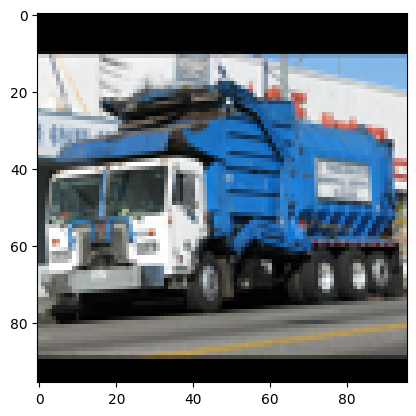

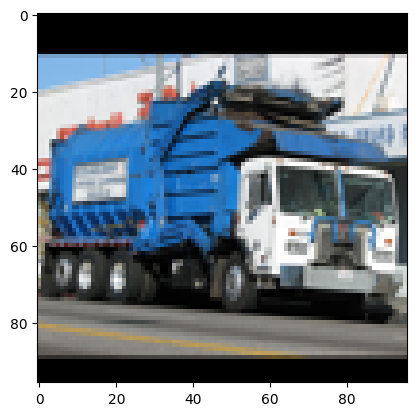

In [47]:
i = random.randint(0,5400)
# i = 0
plot_image(train_images[i])
if i - 4000 >= 0:
    plot_image(train_images[i-4000])
else :
    plot_image(train_images[i+4000])

In [48]:
print(train_images.shape)
print(train_labels.shape)

(16000, 96, 96, 3)
(16000, 10)


### Translation, Shearing, Zooming: Zoom in or out on the image.

In [49]:
# Preprocessing function to add random noise
def add_random_noise(x):
    noise = np.random.normal(0, 0.1, x.shape)  # Generate random noise
    noisy_image = x + noise  # Add noise to the image
    return noisy_image

# Preprocessing function to adjust contrast
def adjust_contrast(x):
    return x
    # contrast_factor = np.random.uniform(0.8, 1.2)  # Adjust contrast by random factor
    # adjusted_image = (x - np.mean(x)) * contrast_factor + np.mean(x)
    # return adjusted_image

def gaussian_blur(x):
    if random.random() <= 0.5 :
        return cv2.GaussianBlur(x, (3, 3), 0)
    else :
        return x

In [50]:
step2 = ImageDataGenerator(
    width_shift_range=0.2,  # Random horizontal shift by 20% of image width
    height_shift_range=0.2,  # Random vertical shift by 20% of image height
    zoom_range=0.2,  # Random zoom in/out by 20%
    shear_range=0.2,
    brightness_range=[0.9, 1.1],  # Random brightness adjustment between 0.5 and 1.5
    preprocessing_function=lambda x: gaussian_blur(adjust_contrast(add_random_noise(x))),  # Gaussian blur with kernel size of (3, 3)
    fill_mode= 'reflect'
)

In [51]:
# numbers of images generated
aug_num = 15000

In [52]:
augmented_generator = step2.flow(train_images.reshape((-1, 96, 96, 3)), train_labels, batch_size=1)

# Generate augmented images and corresponding labels
augmented_images = []
augmented_labels = []
num_augmented_images = 0

for _ in range(aug_num):
    batch = augmented_generator.next()
    augmented_images.append(batch[0][0].astype(np.uint8))
    augmented_labels.append(batch[1])
    num_augmented_images += 1

# Convert the augmented images and labels back to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Verify the shape of the augmented images and labels
print(augmented_images.shape)
print(augmented_labels.shape)

    

(15000, 96, 96, 3)
(15000, 1, 10)


In [53]:
augmented_labels = augmented_labels.reshape(aug_num,10)

In [54]:
train_images = np.append(train_images,augmented_images,axis=0)
train_labels = np.append(train_labels,augmented_labels,axis=0)

### Evalutation de la data augmentation

On réentraine le même modèle mais avec cette fois ci avec le jeu de données d'entrainement augmenté

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

# Définition du callback EarlyStopping pour des raison de temps d'entrainement
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # La métrique à surveiller pour arrêter l'entraînement
    patience=4,          # Nombre de epochs sans amélioration avant de s'arrêter
    restore_best_weights=True  # Restaurer les poids du meilleur modèle
)

In [57]:
history = model_baseline_attention_residu.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(val_images, valid_labels),
                    batch_size = 64,
                    callbacks=[early_stopping_callback],
)

Epoch 1/10
485/485 [==============================] - 376s 775ms/step - loss: 1.6584 - accuracy: 0.3901 - val_loss: 1.5757 - val_accuracy: 0.4040
Epoch 2/10
485/485 [==============================] - 346s 713ms/step - loss: 1.4478 - accuracy: 0.4665 - val_loss: 1.7526 - val_accuracy: 0.4290
Epoch 3/10
485/485 [==============================] - 310s 639ms/step - loss: 1.3154 - accuracy: 0.5201 - val_loss: 1.4954 - val_accuracy: 0.4630
Epoch 4/10
485/485 [==============================] - 312s 643ms/step - loss: 1.1926 - accuracy: 0.5656 - val_loss: 1.5052 - val_accuracy: 0.5080
Epoch 5/10
485/485 [==============================] - 312s 642ms/step - loss: 1.1123 - accuracy: 0.5940 - val_loss: 1.6764 - val_accuracy: 0.4890
Epoch 6/10
485/485 [==============================] - 304s 626ms/step - loss: 1.0451 - accuracy: 0.6204 - val_loss: 1.6513 - val_accuracy: 0.4780
Epoch 7/10
485/485 [==============================] - 337s 694ms/step - loss: 0.9814 - accuracy: 0.6444 - val_loss: 1.6676 -

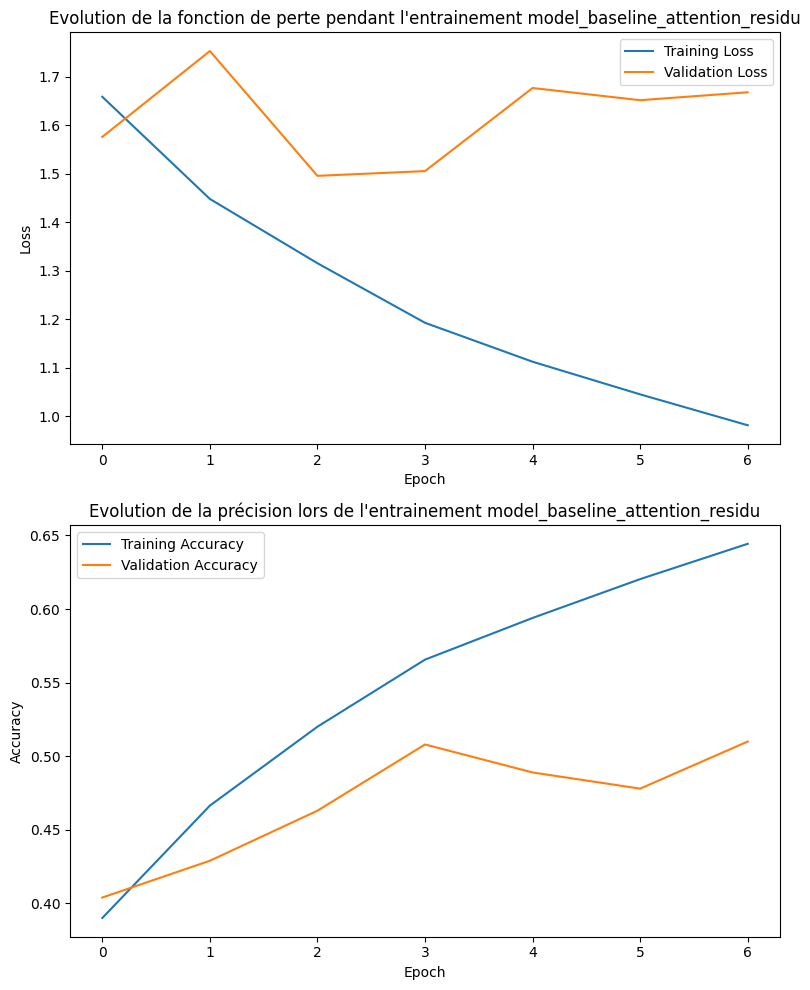

In [58]:
# 2 graphiques en 1
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot de la loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title("Evolution de la fonction de perte pendant l'entrainement model_baseline_attention_residu")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot de la précision
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title("Evolution de la précision lors de l'entrainement model_baseline_attention_residu")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

Nous avons des tendances similaires à ce que nous avons vu sur les modèles précédents pour la précision. Cependant on constate un divergence entre la fonction de loss sur l'ensemble d'entrainement et sur l'ensemble de validation. Nous avons toujours cette problématique de sur apprentissage. Nous avons défini un earlystopping pour ce modèle. En effet la taille du dataset étant augmentée, le temps d'entrainement était devenu trop long. Les résultats semblent meilleurs.

### Evalutaion du modèle baseline avec attention sur les données d'entrainement augmentées.

In [63]:
test_loss, test_accuracy = model_baseline_attention_residu.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

250/250 [==============================] - 17s 66ms/step - loss: 1.4978 - accuracy: 0.4771
Test Loss: 1.4978053569793701
Test Accuracy: 0.47712498903274536


## Apprentissage auto supervisé
### Idée
Dans le cas d'un jeu de données avec des données labellisées et des donnnées non labellisées, l'apprentissage semi supervisé permet d'exploiter l'ensemble du jeu de données. Nous allons tester plusieur méthodes.
### L'auto Encodeur
Un autoencodeur est un réseau de neurones qu'on décompose en 3 éléments. La phase d'encodage, l'espace latent et la phase de décodage.
- L'encodage : C'est une phase qui va être entrainée à résumer nos données d'entrée dans un espace de plus petite dimension. De cette façon, seules les informations les plus imporantes de chaques données sont retenues.(Cette phase correspondra à la feature extraction)
- L'espace latent : C'est l'espace dans lequel nos données sont représentées après la phase d'encodage. Sa dimension sera inférieure à celle de l'espace de départ. Cette plus faible dimension va contraindre notre réseau de neurone à ne conserverver que les éléments les plus importants des données. 
- Le décodage : Cette phase fait le chemin inverse de l'encodage. Elle prend les données dans l'espace latent et va les projeter dans l'espace de départ. Dans notre cas, cette phase nous servira pour entrainer l'encodeur. 

### Un Auto Encodeur pour les classer tous

Dans notre cas, nous voulons construire un classifieur. Un réseau de neurones qui va de l'espace de départ vers l'espace de départ ne nous convient pas.
Cependant, l'espace latent est exploitable. En effet, celui-ci regorge d'informations importantes sur nos données. Il a été construit avec une grande quantité de données non labellisées. Nous allons donc remplacer le décodeur par un classifier et garder l'encodeur et l'espace latent.



![image](https://blog.paperspace.com/content/images/2021/12/image-12.png)

### Charger les images non labellisées 

In [30]:
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'
unlabeled_images = read_all_images(UNLABELED_DATA_PATH)

### Afficheons une des images non labellisées

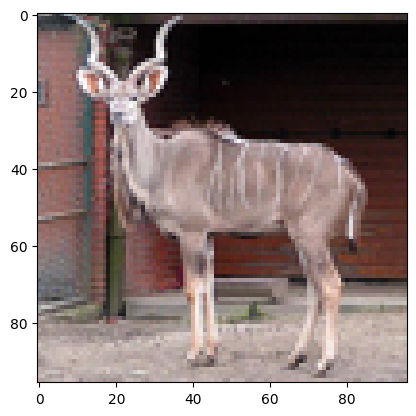

In [66]:
plot_image(unlabeled_images[0])

In [39]:

# Prétraitement des données
input_shape = train_images[0].shape
latent_dim = 64
# On n'arrive pas à entrainer sur l'ensemble de images alors on ne prend que les n premières                                                                                           
nb_of_unlabeled_images = 15000

# Division des données non labellisées en ensembles d'entraînement et de validation
train_images_unlabeled, val_images_unlabeled = train_test_split(unlabeled_images[:nb_of_unlabeled_images], test_size=0.2, random_state=42)

# Normalisation des images
train_images_unlabeled = train_images_unlabeled / 255.0
val_images_unlabeled = val_images_unlabeled / 255.0

# Construction de l'autoencodeur
input_img = Input(shape=input_shape)
                                                                                       
# Encodeur
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu', name='encoded')(x)
# Décodeur
x = Dense(12*12*128, activation='relu')(encoded)
x = tf.reshape(x, shape=(-1, 12, 12, 128))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Modèle de l'autoencodeur
autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 128)       3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        1846

In [40]:
# Compilation et entraînement de l'autoencodeur
autoencoder.compile(optimizer='adam', loss='mse')                                                                       
autoencoder.fit(train_images_unlabeled, train_images_unlabeled, epochs=7, batch_size=128, validation_data=(val_images_unlabeled, val_images_unlabeled))

Epoch 1/7
94/94 [==============================] - 829s 9s/step - loss: 0.0466 - val_loss: 0.0307
Epoch 2/7
94/94 [==============================] - 804s 9s/step - loss: 0.0282 - val_loss: 0.0259
Epoch 3/7
94/94 [==============================] - 844s 9s/step - loss: 0.0259 - val_loss: 0.0249
Epoch 4/7
94/94 [==============================] - 850s 9s/step - loss: 0.0237 - val_loss: 0.0224
Epoch 5/7
94/94 [==============================] - 882s 9s/step - loss: 0.0218 - val_loss: 0.0217
Epoch 6/7
94/94 [==============================] - 908s 10s/step - loss: 0.0210 - val_loss: 0.0207
Epoch 7/7
94/94 [==============================] - 906s 10s/step - loss: 0.0205 - val_loss: 0.0205


In [31]:
# Sauvegarde du modèle
# autoencoder.save('autoencoder_dim_64.keras')

In [36]:
# Version où on crée un nouveau modèle qui comprend l'encodeur
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('encoded').output

# Ajout de la couche Dense de dimension 10 pour la classification
x = Dense(64, activation='relu', name='moins_2')(encoder_output)
x = Dense(32, activation='linear', name='last_dense')(x)
classification_layer = Dense(10, activation='softmax', name='classification')(x)

# Création du modèle complet avec l'encoder et la nouvelle couche de classification
classification_model = Model(inputs=encoder_input, outputs=classification_layer)

# Compilation du modèle
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history_classification_model = classification_model.fit(train_images, 
                                                        train_labels, 
                                                        epochs=3,
                                                        validation_data=(val_images, valid_labels),
                                                        batch_size = 32,)

Epoch 1/3
100/100 [==============================] - 28s 261ms/step - loss: 4.8529 - accuracy: 0.0988 - val_loss: 2.3049 - val_accuracy: 0.0700
Epoch 2/3
100/100 [==============================] - 28s 276ms/step - loss: 2.3023 - accuracy: 0.1103 - val_loss: 2.3078 - val_accuracy: 0.0700
Epoch 3/3
100/100 [==============================] - 29s 292ms/step - loss: 2.3019 - accuracy: 0.1103 - val_loss: 2.3090 - val_accuracy: 0.0700


Cette option donne ne piètres résultats mais l'essaie était tout de même intéressant.

In [73]:
# Évaluation des performances sur l'ensemble de test
test_loss_classification_model, test_accuracy_classification_model = classification_model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss_classification_model)
print('Test Accuracy:', test_accuracy_classification_model)


32/32 [==============================] - 2s 67ms/step - loss: 2.3044 - accuracy: 0.0950
Test Loss: 2.304436683654785
Test Accuracy: 0.0949999988079071


Dans la version suivante nous réalisons une feature extraction. Le modèle est cependant très long à entrainé. Il nous a pris près de deux heures à entrainer en traitant 15k images non labellisées. Nous n'avions pas de GPU pour cet entrainement.

In [16]:
# Version qui va prendre les représentations dans l'espace latent
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('encoded').output
encoder = Model(inputs=encoder_input, outputs=encoder_output)

# On va projeter les données dans l'espace latent pour commencer
encoded_train_images = encoder.predict(train_images)
encoded_test_images = encoder.predict(test_images)

# Crée un modèle de classification avec des couches supplémentaires
classifier = keras.Sequential([
    layers.Dense(64, activation="linear"),
    layers.Dense(10, activation="softmax")
])

# Compile et entraîne le classifieur sur les caractéristiques encodées
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier.fit(encoded_train_images, train_labels, epochs=30, batch_size=32, )  # Utilise les étiquettes d'entraînement appropriées

32/32 [==============================] - 3s 91ms/step
Epoch 1/30
100/100 [==============================] - 1s 2ms/step - loss: 244.4898 - accuracy: 0.1187
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 78.1746 - accuracy: 0.1950
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 41.6871 - accuracy: 0.2319
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 26.0487 - accuracy: 0.2344
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 18.4821 - accuracy: 0.2406
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 19.7660 - accuracy: 0.2175
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 16.9865 - accuracy: 0.2050
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 14.9063 - accuracy: 0.2344
Epoch 9/30
100/100 [==============================] - 0s 2ms/step - loss: 12.7772 - accuracy: 0.2028
Epoch 10/30
100/100 [===============

In [44]:
predicted_val_images_unlabeled2 = autoencoder.predict(val_images_unlabeled)

94/94 [==============================] - 31s 328ms/step


In [ ]:
autoencoder_test_loss, autoencoder_test_accuracy = autoencoder.evaluate(test_images, test_labels)
print(f"Test Loss: {autoencoder_test_loss}")
print(f"Test Accuracy: {autoencoder_test_accuracy}")

#### Exemple d'image et de leur reconstruction
On peut voir que l'autoencodeur ne réussi pas à reconstruire correctement les images même si on devine bien les similarités. Ce manque de performance dans la reconstruction témoigne d'un espace latent qui n'est pas assez bon pour la feature extraction. Les performances de la classification sont effectivement peu convainquantes. 

C:\Users\ramad\AppData\Local\Temp\ipykernel_11308\1305175545.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, n, i+1)


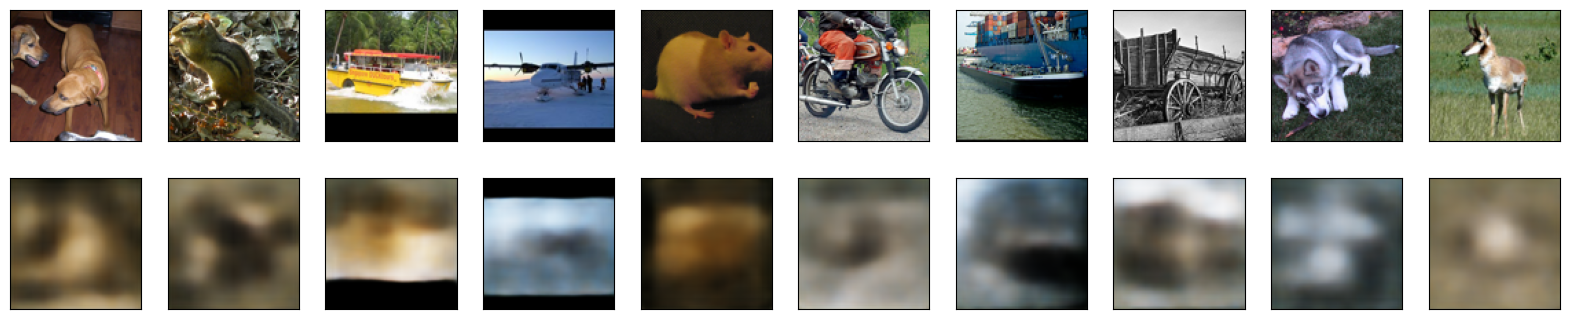

In [76]:
def display_images(original, decoded, count = 10): 
    n = count
    plt.figure(figsize=(20, 4))
    plt.title("Exemple d'image et de leur reconstruction avec l'autoencodeur")
    for i in range(n):
        # show original input image
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[300*i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display decoded image
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(decoded[300*i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
display_images(val_images_unlabeled, predicted_val_images_unlabeled2, count=10)


## Méthode 2: Train + predict + train
On va maintenant faire un entrainement en 3 phases. Pour la première étape nous allons entrainer notre modèle baseline sur les données labellisées. Ensuite nous allon utiliser ce modèle pour classer les données non labellisées. Enfin nous allons entrainer de nouveau notre modèle sur le nouvel ensemble de données.

### On reprend notre modèle baseline
Il va servir à prédire les labels sur les données qui n'en ont pas.

In [34]:
# Prédire les labels des données non annotées
pred_labels_for_unlabeled_data = model_baseline_attention.predict(unlabeled_images[:5000]/255.0)

# Concatener les images pour le train
big_train_images = np.append(train_images, unlabeled_images[:5000], axis=0)

# Concaténer les labels
big_train_labels = np.append(train_labels, pred_labels_for_unlabeled_data, axis=0)

157/157 [==============================] - 12s 73ms/step


In [ ]:
# observons les résultats de cette labellisatoin : 

for i in range(10):
    plot_image(big_train_images[-i])
    print(tf.argmax(big_train_labels[-i]))

In [35]:
# taille du nouveau dataset
print("Le nouveau dataset d'entrainement augmenté et avec les nouvelles données labellisées est de dimensions : ", big_train_images.shape)

Le nouveau dataset d'entrainement augmenté et avec les nouvelles données labellisées est de dimensions :  (28000, 96, 96, 3)


### Nouvel entrainement pour un nouveau jeu de données
Nous allons maintenant réentrainer le modèle sur ce nouvel ensemble de données.

In [37]:
# Donner plus d'importance aux données qui ont de vrais labels

sample_weights = np.ones(len(train_images))  # Initialisation avec des poids égaux
sample_weights[:4000] = 2.0  # Donnez plus d'importance aux 5000 premiers échantillons

# fit du nouveau modèle
big_history = model_baseline_attention.fit(
                    train_images, train_labels,
                    epochs=5,
                    validation_data=(val_images, valid_labels),
                    batch_size = 256,)


Epoch 1/5
90/90 [==============================] - 255s 3s/step - loss: 0.8429 - accuracy: 0.6945 - val_loss: 1.6931 - val_accuracy: 0.5310
Epoch 2/5
90/90 [==============================] - 251s 3s/step - loss: 0.7450 - accuracy: 0.7315 - val_loss: 1.8707 - val_accuracy: 0.5360
Epoch 3/5
90/90 [==============================] - 248s 3s/step - loss: 0.6691 - accuracy: 0.7600 - val_loss: 1.8657 - val_accuracy: 0.5230
Epoch 4/5
90/90 [==============================] - 214s 2s/step - loss: 0.6142 - accuracy: 0.7804 - val_loss: 2.1792 - val_accuracy: 0.5270
Epoch 5/5
90/90 [==============================] - 211s 2s/step - loss: 0.5834 - accuracy: 0.7898 - val_loss: 2.3011 - val_accuracy: 0.5090


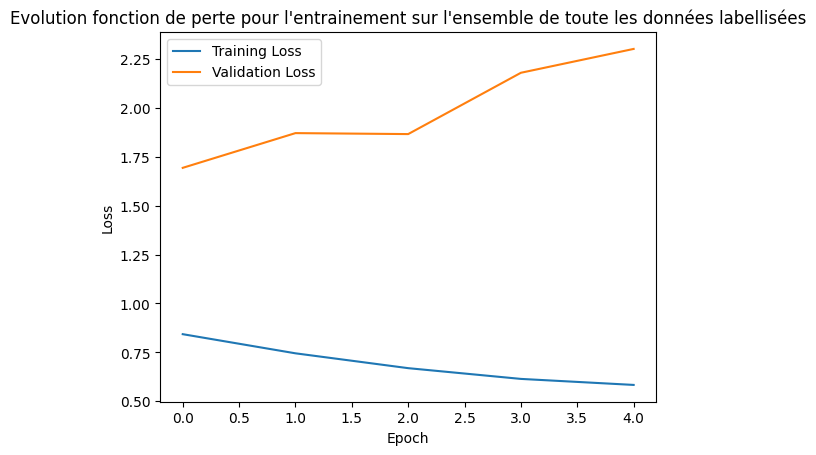

In [65]:
# Affiche le graphique de la loss
plt.plot(big_history.history['loss'], label='Training Loss')
plt.plot(big_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution fonction de perte pour l'entrainement sur l'ensemble de toute les données labellisées")
plt.legend()
plt.show()

In [38]:
# Évaluation des performances sur l'ensemble de test
test_loss_big_train, test_accuracy_big_train = model_baseline_attention.evaluate(test_images, test_labels)
print('Test Loss:', test_loss_big_train)
print('Test Accuracy:', test_accuracy_big_train)

250/250 [==============================] - 19s 78ms/step - loss: 2.3065 - accuracy: 0.5086
Test Loss: 2.3064944744110107
Test Accuracy: 0.5086249709129333


## Conclusion

#### Baseline
Pour la baseline nous avons choisi de partir d'un modèle CNN. C'est l'architecture qui s'est imposée pour le traitement des données graphiques. Nous avons exploré deux évolutions de ce réseau de neurones. La première en ajoutant une couche d'**attention** et la seconde en intégrant un **résidu**. 
L'ajout de l'attention a montré une amélioration des performances de l'algorithme sur les données de test. L'ajout du résidu n'a quand à lui pas montré de changement dans les performances. Il est possible qu'une intégration différente du résidu ait donné de meilleurs résultats.
#### Augmentation des données
L'augmentation des donné
Nous avons fait tout d'abord fait un retournement d'image sur un axe vertical. Nous avons également opéré aléatoirement des translations, du bruit gaussien et un effet de flou et un zoom/dézoom. Ces opération permettent d'extrapoler des données à partir de celles que nous avons. Les données labellisées étant les plus précieuses que nous avons, cette phase permet d'en exploiter le maximum de potentiel. l'augmentation des données a montrer une amélioration des performances des algorithmes précédents. Nous sommes passés d'une précision de 40% à 48% sur l'ensemble de test.

#### Feature extraction avec un modèle pré entrainé
CLIP (Contrastive Language-Image Pre-Training) est un réseau de neurones formé sur une variété de paires (image, texte). CLIP peut réaliser du zeroshot learning et utilise des transformers, c'est un modèle à l'état de l'art dans son architecture. Sur ImageNet "zero-shot" sans utiliser aucun des exemples étiquetés originaux de 1,28 million, surmontant plusieurs défis majeurs de la vision par ordinateur.
La feature extraction avec CLIP nous a donné les meilleurs résultats avec une précision de 97%.

#### Apprentissage auto supervisé
L'utilisation d'un auto encodeur nous a permis de réaliser un apprentissage auto supervisé. Cette méthode nous a permi d'exploiter les données non labellisées. Nous n'avons cependant pas réussi à exploiter l'ensemble de ces donnnées avec nos ressources. Les résultats obtenus ne sont pas à la hauteur des autres approches. 

#### Comparaison des performences
Nous pouvons dire que la feature extraction faite avec le modèle CLIP a donnée de loin les meilleures performances. L'augmentation des données et l'utilisaton de l'attention ont également montré un intéret certain dans l'amélioration de nos algorithmes de classification.

#### Ouverture
Il peut être intéressant de faire une étude approfondie de nos modèles pour mieux les comprendre. Une étude des classes sur lesquelles ils ont le plus de difficultés par exemple. Une étude sur les classes qui sont le plus souvent confondues peut donner des pites d'amélioration. On pourrait également regarder les pixels qui sont les plus déterminantes dans les prédictions.

#### Graphique de la comparaison des performances des différents modèles

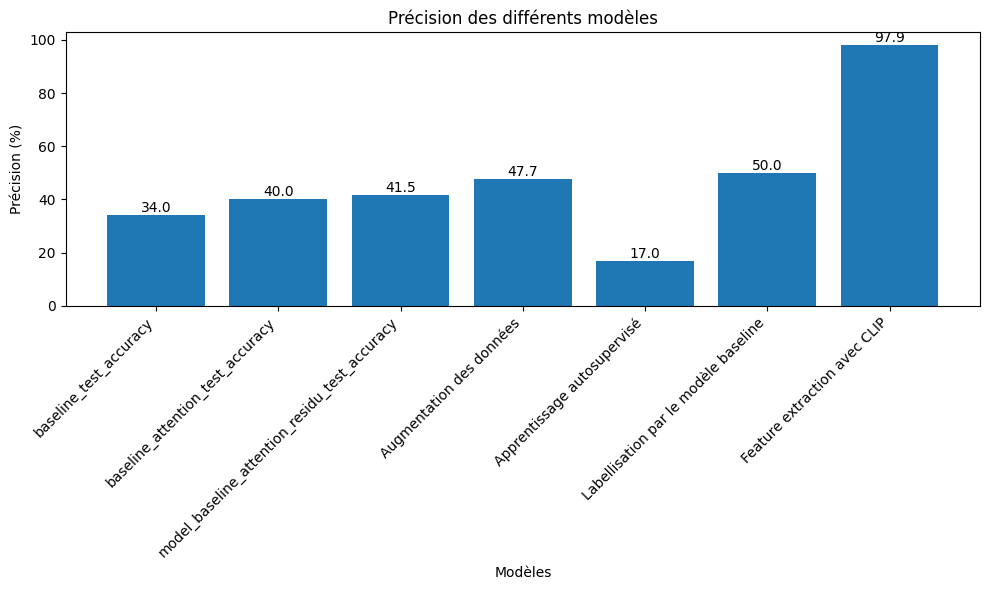

In [30]:
import matplotlib.pyplot as plt

dict_des_precisions = {
    "baseline_test_accuracy": 34.0,
    "baseline_attention_test_accuracy": 40.0,
    "model_baseline_attention_residu_test_accuracy": 41.5,
    "Augmentation des données": 47.7,
    "Apprentissage autosupervisé": 17.0,
    "Labellisation par le modèle baseline": 50.0,
    "Feature extraction avec CLIP": 97.9
}

# Extraire les clés et les valeurs du dictionnaire
labels = list(dict_des_precisions.keys())
precisions = list(dict_des_precisions.values())

# Créer le graphique en barres
plt.figure(figsize=(10, 6))
plt.bar(labels, precisions)

# Ajouter les labels aux barres
for i in range(len(labels)):
    plt.text(i, precisions[i], str(precisions[i]), ha='center', va='bottom')

# Ajouter des titres et des labels
plt.xlabel('Modèles')
plt.ylabel('Précision (%)')
plt.title('Précision des différents modèles')

# Faire pivoter les labels de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()
